# Phishing Website Detection — End-to-End (Professional)

Notebook expects:

```
html_content/
  genuine_site_0/
  phishing_site_1/
URL_data.csv (optional)
Email_data.csv (optional)
```

Change configuration in the first code cell and run sequentially.

In [1]:
# Configuration
DATA_DIR = 'C:/Users/parth/Desktop/phising_Website Detection/website + Text'
GENUINE_SUBFOLDER = 'C:/Users/parth/Desktop/phising_Website Detection/website + Text/genuine_site_0'
PHISH_SUBFOLDER = 'C:/Users/parth/Desktop/phising_Website Detection/website + Text/phishing_site_1'
URL_CSV = 'C:/Users/parth/Desktop/phising_Website Detection/Phish_URL.csv'  # optional
EMAIL_CSV = 'C:/Users/parth/Desktop/phising_Website Detection/Phishing_Email.csv'  # optional
OUT_DIR = 'output_notebook'
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 256
BATCH_SIZE = 8
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
VAL_SIZE = 0.15
SEED = 42
print('Config set')

Config set


In [3]:
import os, random, time
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils import shuffle

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

import warnings
warnings.filterwarnings('ignore')
print('Imports ready')

Imports ready


In [4]:
def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def html_to_text(html):
    if not isinstance(html, str) or len(html.strip())==0:
        return ''
    soup = BeautifulSoup(html, 'lxml')
    for t in soup(['script','style','noscript']):
        t.decompose()
    return ' '.join(soup.get_text(separator=' ').split())

def read_text_files_from_dir(dir_path, label):
    records = []
    p = Path(dir_path)
    if not p.exists():
        return pd.DataFrame(columns=['url','website_html','label'])
    for f in sorted(p.iterdir()):
        if not f.is_file():
            continue
        try:
            content = f.read_text(encoding='utf-8', errors='ignore')
        except Exception:
            continue
        name = f.stem
        url_part = name.split('_')[0]
        records.append({'url': url_part, 'website_html': content, 'label': int(label)})
    return pd.DataFrame.from_records(records)

print('Utils defined')

Utils defined


In [5]:
fix_seed(SEED)
base = Path(DATA_DIR)

df_genuine = read_text_files_from_dir(base/GENUINE_SUBFOLDER, 0)
df_phish = read_text_files_from_dir(base/PHISH_SUBFOLDER, 1)
print('Genuine:', len(df_genuine), 'Phishing:', len(df_phish))
frames = [df_genuine, df_phish]

if Path(URL_CSV).exists():
    df_url = pd.read_csv(URL_CSV)
    if 'url' in df_url.columns and 'label' in df_url.columns:
        df_url['website_html']=''
        df_url['email_text']=''
        frames.append(df_url[['url','website_html','email_text','label']])
        print('Loaded URL CSV:', len(df_url))

if Path(EMAIL_CSV).exists():
    df_email = pd.read_csv(EMAIL_CSV)
    if 'email_text' in df_email.columns and 'label' in df_email.columns:
        df_email['url']=df_email.get('url','')
        df_email['website_html']=''
        frames.append(df_email[['url','website_html','email_text','label']])
        print('Loaded Email CSV:', len(df_email))

combined = pd.concat(frames, ignore_index=True, sort=False).fillna('')
for c in ['url','website_html','email_text','label']:
    if c not in combined.columns:
        combined[c]=''
combined = combined[['url','website_html','email_text','label']]
combined = shuffle(combined, random_state=SEED).reset_index(drop=True)
print('Combined shape:', combined.shape)
combined.head()

Genuine: 1312 Phishing: 553
Combined shape: (1865, 4)


,url,website_html,email_text,label
0,genuine,"<html lang=""en-US"" xml:lang=""en-US"" dir=""ltr"" ...",,0
1,genuine,<!DOCTYPE html><html><head><script>window.onlo...,,0
2,genuine,"<!DOCTYPE html><html style=""font-size: 10px;fo...",,0
3,genuine,"\n<!DOCTYPE html>\n<html lang=""en"">\n<head>\n ...",,0
4,genuine,<!DOCTYPE HTML>\n<!--\n\tPrologue by HTML5 UP\...,,0


In [6]:
print('Null counts:')
print(combined.isnull().sum())
combined['url']=combined['url'].astype(str).fillna('')
combined['website_html']=combined['website_html'].astype(str).fillna('')
combined['email_text']=combined['email_text'].astype(str).fillna('')
combined['label']=combined['label'].astype(int)
print('\nLabel distribution:\n', combined['label'].value_counts())

Null counts:
url             0
website_html    0
email_text      0
label           0
dtype: int64

Label distribution:
 label
0    1312
1     553
Name: count, dtype: int64


In [7]:
print('Extracting text from HTML...')
combined['html_text'] = combined['website_html'].apply(html_to_text)
combined['content_text'] = (combined['email_text'].str.strip() + ' ' + combined['html_text'].str.strip()).str.strip()
combined['content_text'] = combined.apply(lambda r: r['content_text'] if len(r['content_text'])>10 else r['url'], axis=1)
combined = combined[combined['content_text'].str.len()>5].reset_index(drop=True)
print('After extraction shape:', combined.shape)
combined[['url','label']].head()

Extracting text from HTML...
After extraction shape: (1865, 6)


,url,label
0,genuine,0
1,genuine,0
2,genuine,0
3,genuine,0
4,genuine,0


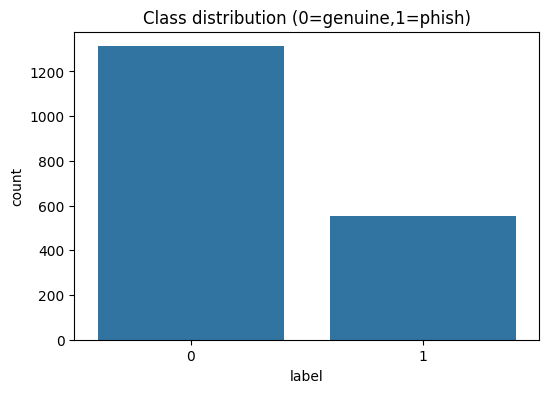

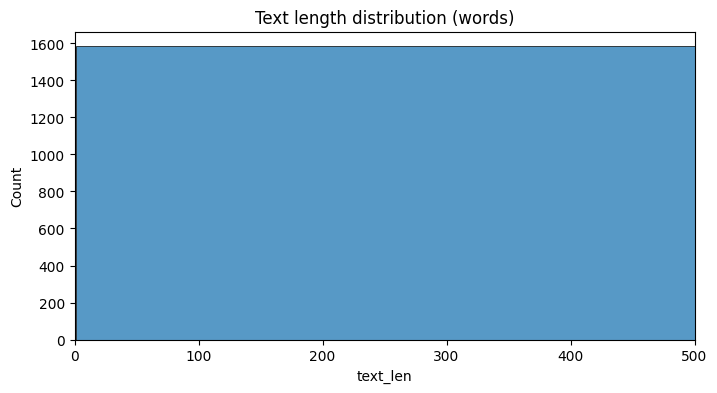

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x=combined['label'])
plt.title('Class distribution (0=genuine,1=phish)')
plt.show()

combined['text_len'] = combined['content_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
sns.histplot(combined['text_len'], bins=80)
plt.xlim(0,500)
plt.title('Text length distribution (words)')
plt.show()

In [9]:
texts = combined['content_text'].tolist()
labels = combined['label'].astype(int).tolist()
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=VAL_SIZE, random_state=SEED, stratify=labels)
print('Train/Val sizes:', len(X_train), len(X_val))
from collections import Counter
print('Train label counts:', Counter(y_train))

Train/Val sizes: 1585 280
Train label counts: Counter({0: 1115, 1: 470})


In [10]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer.encode_plus(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        return {'input_ids':enc['input_ids'].squeeze(0),'attention_mask':enc['attention_mask'].squeeze(0),'labels':torch.tensor(self.labels[idx],dtype=torch.long)}

print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_ds = TextDataset(X_train, y_train, tokenizer, max_len=MAX_LEN)
val_ds = TextDataset(X_val, y_val, tokenizer, max_len=MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print('Dataloaders prepared')

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Dataloaders prepared


In [11]:
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

unique, counts = np.unique(y_train, return_counts=True)
class_count = dict(zip(unique,counts))
weight0 = weight1 = 1.0
if 0 in class_count and 1 in class_count:
    weight0 = (len(y_train)/(2.0*class_count[0]))
    weight1 = (len(y_train)/(2.0*class_count[1]))
class_weights = torch.tensor([weight0, weight1], dtype=torch.float).to(device)
print('Class weights:', class_weights.cpu().numpy())
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.06*total_steps), num_training_steps=total_steps)
print('Training setup ready')

Loading model...


ImportError: Traceback (most recent call last):
  File "C:\Users\parth\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
os.makedirs(OUT_DIR, exist_ok=True)
train_losses=[]; val_losses=[]; val_f1s=[]
best_f1=0.0; best_path=None
for epoch in range(1, EPOCHS+1):
    model.train()
    t0=time.time(); tot_loss=0.0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device); attention_mask = batch['attention_mask'].to(device); labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step(); scheduler.step()
        tot_loss += loss.item()
    avg_train = tot_loss/len(train_loader); train_losses.append(avg_train)
    # validation
    model.eval(); preds=[]; trues=[]; vloss=0.0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device); attention_mask = batch['attention_mask'].to(device); labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
            logits = outputs.logits
            loss = loss_fn(logits, labels); vloss += loss.item()
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist()); trues.extend(labels.cpu().numpy().tolist())
    avg_val = vloss/len(val_loader); val_losses.append(avg_val)
    p,r,f1,_ = precision_recall_fscore_support(trues, preds, average='binary', zero_division=0); val_f1s.append(f1)
    t1=time.time()
    print(f'Epoch {epoch}/{EPOCHS} train_loss={avg_train:.4f} val_loss={avg_val:.4f} val_f1={f1:.4f} time={(t1-t0):.1f}s')
    if f1 > best_f1:
        best_f1=f1; best_path = os.path.join(OUT_DIR, f'best_model_epoch{epoch}_f1{f1:.4f}.pt')
        torch.save(model.state_dict(), best_path); tokenizer.save_pretrained(os.path.join(OUT_DIR, 'tokenizer')); print('Saved best model to', best_path)

model.save_pretrained(os.path.join(OUT_DIR, 'final_model')); tokenizer.save_pretrained(os.path.join(OUT_DIR, 'final_tokenizer'))
print('Training finished, artifacts saved to', OUT_DIR)

In [ ]:
# Evaluation
try:
    if best_path:
        model.load_state_dict(torch.load(best_path, map_location=device))
        print('Loaded best model:', best_path)
except Exception:
    pass

all_preds=[]; all_trues=[]; model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids=batch['input_ids'].to(device); attention_mask=batch['attention_mask'].to(device); labels=batch['labels'].to(device)
        outputs=model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy().tolist())
        all_trues.extend(labels.cpu().numpy().tolist())

print('Accuracy:', accuracy_score(all_trues, all_preds))
print('\nClassification report:\n')
print(classification_report(all_trues, all_preds, digits=4))
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()

In [ ]:
# Training curves
plt.figure(figsize=(8,4)); plt.plot(train_losses, label='train_loss'); plt.plot(val_losses, label='val_loss'); plt.legend(); plt.title('Loss curves'); plt.show()
plt.figure(figsize=(8,4)); plt.plot(val_f1s, label='val_f1'); plt.title('Validation F1'); plt.show()

In [ ]:
# Inference helper
def predict_text(text, tokenizer, model, device, max_len=MAX_LEN):
    enc = tokenizer.encode_plus(text, truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
    input_ids = enc['input_ids'].to(device); attention_mask = enc['attention_mask'].to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[0].cpu().numpy()
    return {'prob_legit': float(probs[0]), 'prob_phish': float(probs[1])}

print('Example inference:'); print(predict_text('Your account has been suspended. Click to verify.', tokenizer, model, device))